In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
import gc


In [4]:
# Simple CNN
simple_cnn = models.Sequential([
    layers.Conv2D(32, (3, 3), padding='same', use_bias=False, activation='relu', input_shape=(32, 32, 3)),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, (3, 3), padding='same', use_bias=False, activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

simple_cnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.002),
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

# Improved CNN
optimized_cnn = models.Sequential([
    layers.Conv2D(32, (3, 3), padding='same', use_bias=False, input_shape=(32, 32, 3)),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, (3, 3), padding='same', use_bias=False),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(10, activation='softmax')
])

optimized_cnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.002),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

# Adversarially-Trained CNN (Identical to Improved CNN, but trained on adversarial data)
adv_trained_cnn = tf.keras.models.clone_model(optimized_cnn)
adv_trained_cnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.002),
                        loss='sparse_categorical_crossentropy',
                        metrics=['accuracy'])

# Hybrid CNN (Trained on both clean and adversarial data)
hybrid_cnn = tf.keras.models.clone_model(optimized_cnn)
hybrid_cnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.002),
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [6]:
# Load dataset
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Normalize images to [0,1] range
X_train, X_test = X_train / 255.0, X_test / 255.0


In [8]:
# Train Simple and Improved CNNs on Clean Data
history_simple = simple_cnn.fit(X_train, y_train, epochs=30, batch_size=64, validation_data=(X_test, y_test))
history_improved = optimized_cnn.fit(X_train, y_train, epochs=30, batch_size=64, validation_data=(X_test, y_test))

# Generate FGSM Adversarial Examples for Training Adversarial Models (ε = 0.01)
def fgsm_attack(model, images, labels, epsilon=0.01):
    images = tf.convert_to_tensor(images, dtype=tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(images)
        predictions = model(images)
        loss = tf.keras.losses.sparse_categorical_crossentropy(labels, predictions)
    gradient = tape.gradient(loss, images)
    signed_grad = tf.sign(gradient)
    adversarial_images = images + epsilon * signed_grad
    return tf.clip_by_value(adversarial_images, 0, 1).numpy()

X_train_adv = fgsm_attack(optimized_cnn, X_train, y_train, epsilon=0.01)

# Train Adversarially-Trained CNN on Adversarial Data
history_adv_trained = adv_trained_cnn.fit(X_train_adv, y_train, epochs=30, batch_size=64, validation_data=(X_test, y_test))

# Train Hybrid CNN on Clean + Adversarial Data
X_train_hybrid = np.concatenate([X_train, X_train_adv])
y_train_hybrid = np.concatenate([y_train, y_train])
history_hybrid = hybrid_cnn.fit(X_train_hybrid, y_train_hybrid, epochs=30, batch_size=64, validation_data=(X_test, y_test))


Epoch 1/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.4050 - loss: 1.6360 - val_accuracy: 0.6262 - val_loss: 1.0818
Epoch 2/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.6429 - loss: 1.0220 - val_accuracy: 0.6550 - val_loss: 1.0051
Epoch 3/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.6972 - loss: 0.8765 - val_accuracy: 0.6890 - val_loss: 0.9200
Epoch 4/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.7302 - loss: 0.7790 - val_accuracy: 0.6906 - val_loss: 0.8998
Epoch 5/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.7595 - loss: 0.6841 - val_accuracy: 0.7003 - val_loss: 0.9004
Epoch 6/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.7843 - loss: 0.6181 - val_accuracy: 0.6982 - val_loss: 0.9254
Epoch 7/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.8042 - loss: 0.5570 - val_accuracy: 0.6939 - val_loss: 0.9650
Epoch 8/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.8249 - loss: 0.4997 - val_

In [10]:
# Generate FGSM Test Sets
X_test_adv_001 = fgsm_attack(optimized_cnn, X_test, y_test, epsilon=0.01)
X_test_adv_005 = fgsm_attack(optimized_cnn, X_test, y_test, epsilon=0.05)

# Evaluate Models
models = {
    "Simple CNN": simple_cnn,
    "Improved CNN": optimized_cnn,
    "Adversarially-Trained CNN": adv_trained_cnn,
    "Hybrid CNN": hybrid_cnn
}

adv_accuracies_001 = {}
adv_accuracies_005 = {}

for model_name, model in models.items():
    _, acc_001 = model.evaluate(X_test_adv_001, y_test, verbose=0)
    _, acc_005 = model.evaluate(X_test_adv_005, y_test, verbose=0)
    adv_accuracies_001[model_name] = acc_001
    adv_accuracies_005[model_name] = acc_005
    print(f"{model_name}: ε=0.01 Accuracy: {acc_001:.4f}, ε=0.05 Accuracy: {acc_005:.4f}")


Simple CNN: ε=0.01 Accuracy: 0.6065, ε=0.05 Accuracy: 0.3542
Improved CNN: ε=0.01 Accuracy: 0.1909, ε=0.05 Accuracy: 0.0516
Adversarially-Trained CNN: ε=0.01 Accuracy: 0.6448, ε=0.05 Accuracy: 0.5214
Hybrid CNN: ε=0.01 Accuracy: 0.6386, ε=0.05 Accuracy: 0.4584


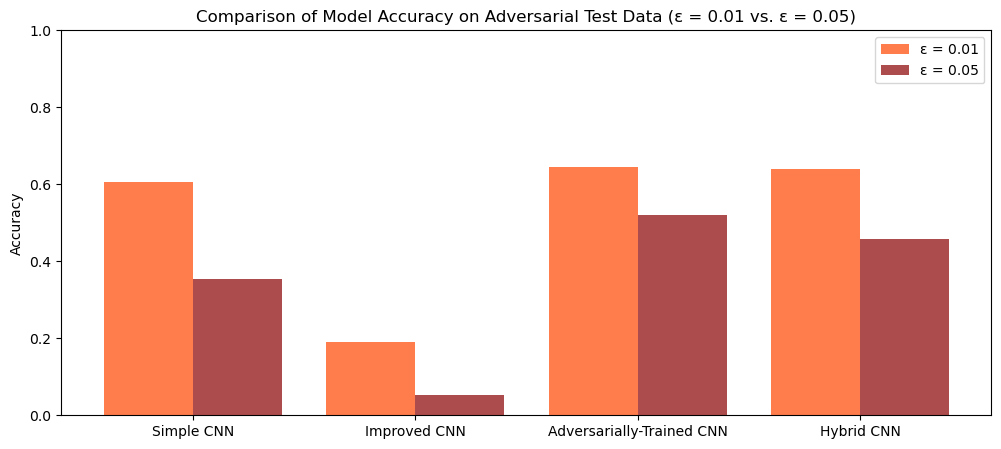

In [12]:
# Plot Adversarial Accuracy for ε = 0.01 vs. ε = 0.05
plt.figure(figsize=(12, 5))
bar_width = 0.4
x = np.arange(len(models))

plt.bar(x - bar_width / 2, list(adv_accuracies_001.values()), bar_width, label="ε = 0.01", alpha=0.7, color="orangered")
plt.bar(x + bar_width / 2, list(adv_accuracies_005.values()), bar_width, label="ε = 0.05", alpha=0.7, color="darkred")

plt.xticks(ticks=x, labels=models.keys())
plt.ylabel("Accuracy")
plt.title("Comparison of Model Accuracy on Adversarial Test Data (ε = 0.01 vs. ε = 0.05)")
plt.legend()
plt.ylim(0, 1)

plt.show()


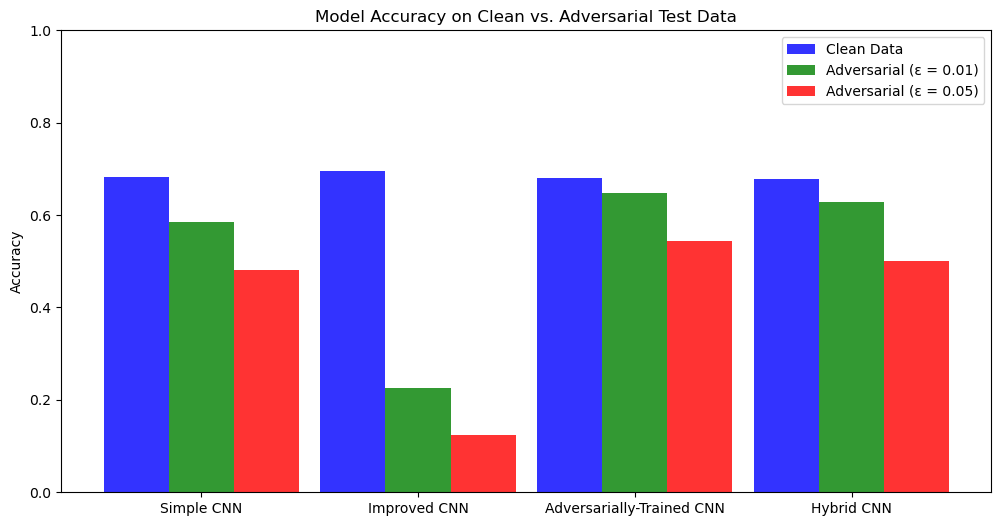

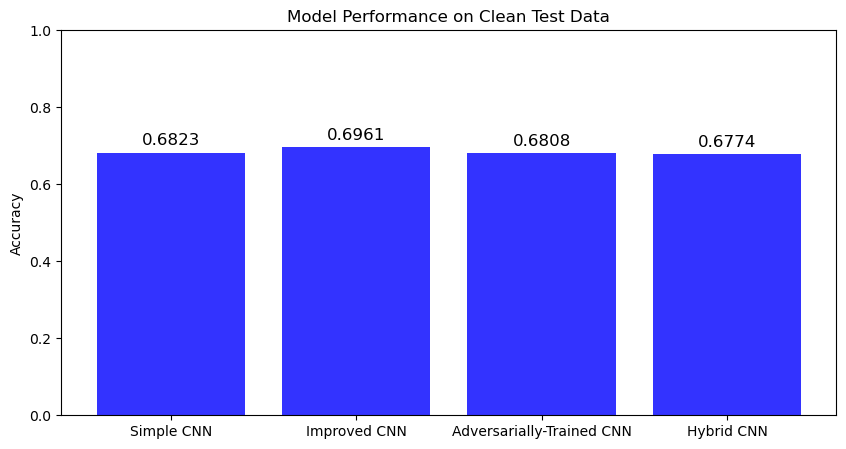

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Define scientific color scheme
colors = ["blue", "green", "red"]  # Clean, ε=0.01, ε=0.05

model_names = ["Simple CNN", "Improved CNN", "Adversarially-Trained CNN", "Hybrid CNN"]


# 📊 **Plot: Clean vs. Adversarial Accuracy Comparison**
plt.figure(figsize=(12, 6))
bar_width = 0.3
x = np.arange(len(model_names))

# Plot Clean Data Accuracy
plt.bar(x - bar_width, clean_accuracies, bar_width, label="Clean Data", alpha=0.8, color=colors[0])

# Plot Adversarial Accuracy (ε = 0.01)
plt.bar(x, adv_accuracies_001, bar_width, label="Adversarial (ε = 0.01)", alpha=0.8, color=colors[1])

# Plot Adversarial Accuracy (ε = 0.05)
plt.bar(x + bar_width, adv_accuracies_005, bar_width, label="Adversarial (ε = 0.05)", alpha=0.8, color=colors[2])

plt.xticks(ticks=x, labels=model_names)
plt.ylabel("Accuracy")
plt.title("Model Accuracy on Clean vs. Adversarial Test Data")
plt.legend()
plt.ylim(0, 1)

plt.show()

# 📊 **Separate Plot: Clean Accuracy Across All Models**
plt.figure(figsize=(10, 5))
plt.bar(model_names, clean_accuracies, color=colors[0], alpha=0.8)
plt.ylabel("Accuracy")
plt.title("Model Performance on Clean Test Data")
plt.ylim(0, 1)

# Add values on top of bars
for i, v in enumerate(clean_accuracies):
    plt.text(i, v + 0.02, f"{v:.4f}", ha="center", fontsize=12)

plt.show()


In [40]:
import pandas as pd

# Function to extract final accuracy, loss, validation accuracy, and validation loss
def extract_final_metrics(history):
    return {
        "Accuracy": history.history['accuracy'][-1],
        "Loss": history.history['loss'][-1],
        "Validation Accuracy": history.history['val_accuracy'][-1],
        "Validation Loss": history.history['val_loss'][-1]
    }

# Collect metrics from each trained model
clean_metrics = {
    "Simple CNN": extract_final_metrics(history_simple),
    "Improved CNN": extract_final_metrics(history_improved),
    "Adversarially-Trained CNN": extract_final_metrics(history_adv_trained),
    "Hybrid CNN": extract_final_metrics(history_hybrid)
}

# Convert to Pandas DataFrame
df_clean = pd.DataFrame(clean_metrics).T

# Display table
from IPython.display import display
display(df_clean)


,Accuracy,Loss,Validation Accuracy,Validation Loss
Simple CNN,0.95696,0.122894,0.6715,2.591653
Improved CNN,0.90794,0.254873,0.6795,1.746934
Adversarially-Trained CNN,0.91654,0.232411,0.6696,1.782604
Hybrid CNN,0.92168,0.214894,0.6722,2.079923


In [44]:
# Extract metrics for adversarial dataset testing
adv_metrics = {
    "Model": model_names,
    "Accuracy (ε=0.01)": adv_accuracies_001,  # Directly use the list
    "Accuracy (ε=0.05)": adv_accuracies_005   # Directly use the list
}

# Convert to DataFrame
df_adv = pd.DataFrame(adv_metrics)

# Display table
from IPython.display import display
display(df_adv)


,Model,Accuracy (ε=0.01),Accuracy (ε=0.05)
0,Simple CNN,0.5858,0.4821
1,Improved CNN,0.2265,0.1245
2,Adversarially-Trained CNN,0.6481,0.5432
3,Hybrid CNN,0.6288,0.5012


In [46]:
import pandas as pd
from IPython.display import display

# Extract the final loss and validation loss values from training histories
clean_losses = [
    history_simple.history['loss'][-1],
    history_improved.history['loss'][-1],
    history_adv_trained.history['loss'][-1],
    history_hybrid.history['loss'][-1]
]

clean_val_accuracies = [
    history_simple.history['val_accuracy'][-1],
    history_improved.history['val_accuracy'][-1],
    history_adv_trained.history['val_accuracy'][-1],
    history_hybrid.history['val_accuracy'][-1]
]

clean_val_losses = [
    history_simple.history['val_loss'][-1],
    history_improved.history['val_loss'][-1],
    history_adv_trained.history['val_loss'][-1],
    history_hybrid.history['val_loss'][-1]
]

# Define the ultimate comparison table with variables
combined_data = {
    "Model": model_names,
    "Clean Accuracy": clean_accuracies,
    "Clean Loss": clean_losses,
    "Clean Val Accuracy": clean_val_accuracies,
    "Clean Val Loss": clean_val_losses,
    "Adv Accuracy (ε=0.01)": adv_accuracies_001,
    "Adv Accuracy (ε=0.05)": adv_accuracies_005
}

# Convert to DataFrame
df_combined = pd.DataFrame(combined_data)

# Display the table
display(df_combined)


,Model,Clean Accuracy,Clean Loss,Clean Val Accuracy,Clean Val Loss,Adv Accuracy (ε=0.01),Adv Accuracy (ε=0.05)
0,Simple CNN,0.6823,0.122894,0.6715,2.591653,0.5858,0.4821
1,Improved CNN,0.6961,0.254873,0.6795,1.746934,0.2265,0.1245
2,Adversarially-Trained CNN,0.6808,0.232411,0.6696,1.782604,0.6481,0.5432
3,Hybrid CNN,0.6774,0.214894,0.6722,2.079923,0.6288,0.5012


In [57]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import tensorflow as tf

def compute_fpr_tpr_auc(model, X_test, y_test):
    """
    Computes False Positive Rate (FPR), True Positive Rate (TPR), and AUC for a given model.
    Plots the ROC curve.
    """
    # Get model predictions (softmax probabilities)
    y_probs = model.predict(X_test)  
    y_pred = np.argmax(y_probs, axis=1)  

    # Convert y_test to one-hot encoding
    y_test_one_hot = tf.keras.utils.to_categorical(y_test, num_classes=10)

    # Initialize plot
    plt.figure(figsize=(8, 6))

    # Compute FPR, TPR, and AUC for each class
    for i in range(10):  # Assuming 10 classes in CIFAR-10
        fpr, tpr, _ = roc_curve(y_test_one_hot[:, i], y_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

    # Plot ROC Curve
    plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing (AUC = 0.50)")
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('ROC Curve for CIFAR-10 Model')
    plt.legend()
    plt.show()

    return fpr, tpr, roc_auc


In [61]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def compute_auc(model, X_test, y_test):
    """
    Computes the AUC (Area Under the Curve) for a given model.
    Returns the macro-average AUC score.
    """
    # Get model predictions (softmax probabilities)
    y_probs = model.predict(X_test)  
    y_probs = tf.nn.softmax(y_probs, axis=1).numpy()  # Ensure softmax is applied

    # Convert y_test to one-hot encoding
    y_test_one_hot = tf.keras.utils.to_categorical(y_test, num_classes=10)

    # Compute macro-average AUC
    auc_scores = []
    for i in range(10):  # Assuming 10 classes in CIFAR-10
        fpr, tpr, _ = roc_curve(y_test_one_hot[:, i], y_probs[:, i])
        roc_auc = auc(fpr, tpr)
        auc_scores.append(roc_auc)

    macro_auc = np.mean(auc_scores)  # Compute macro-average AUC
    return macro_auc


In [63]:
# Compute AUC for all models
auc_simple = compute_auc(simple_cnn, X_test, y_test)
auc_optimized = compute_auc(optimized_cnn, X_test, y_test)
auc_adv_trained = compute_auc(adv_trained_cnn, X_test, y_test)
auc_hybrid = compute_auc(hybrid_cnn, X_test, y_test)

# Create a table to compare AUC scores across models
auc_data = {
    "Model": ["Simple CNN", "Optimized CNN", "Adversarially-Trained CNN", "Hybrid CNN"],
    "AUC Score": [auc_simple, auc_optimized, auc_adv_trained, auc_hybrid]
}

# Convert to DataFrame and display
df_auc = pd.DataFrame(auc_data)
display(df_auc)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


,Model,AUC Score
0,Simple CNN,0.903400
1,Optimized CNN,0.917729
2,Adversarially-Trained CNN,0.915349
3,Hybrid CNN,0.911589


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


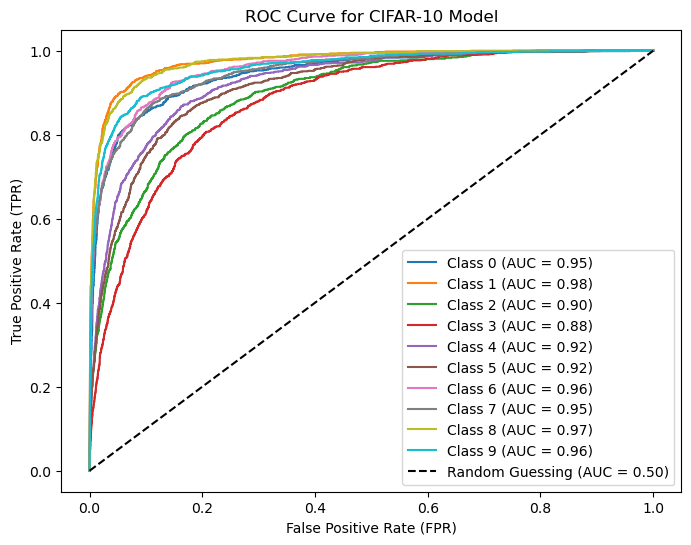

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


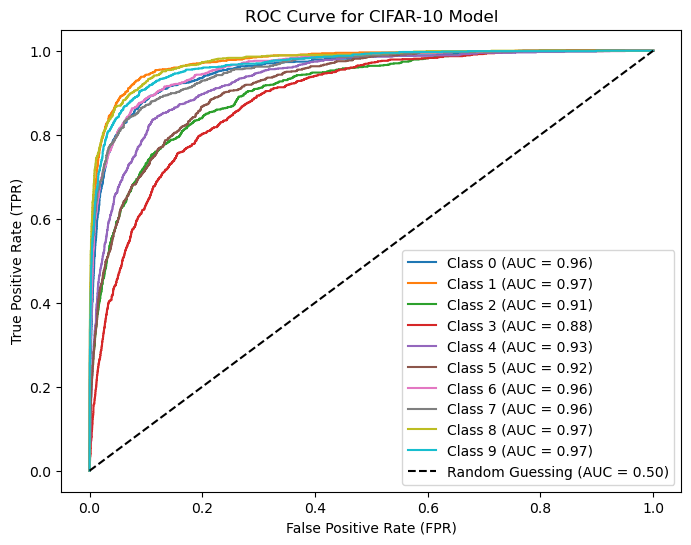

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


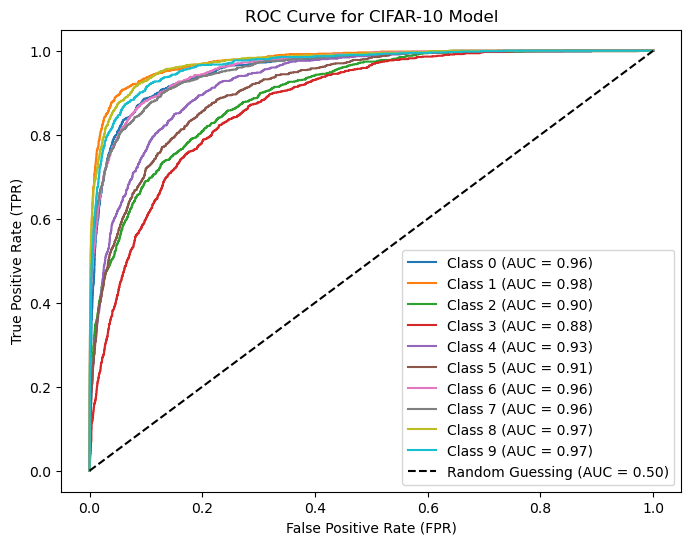

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


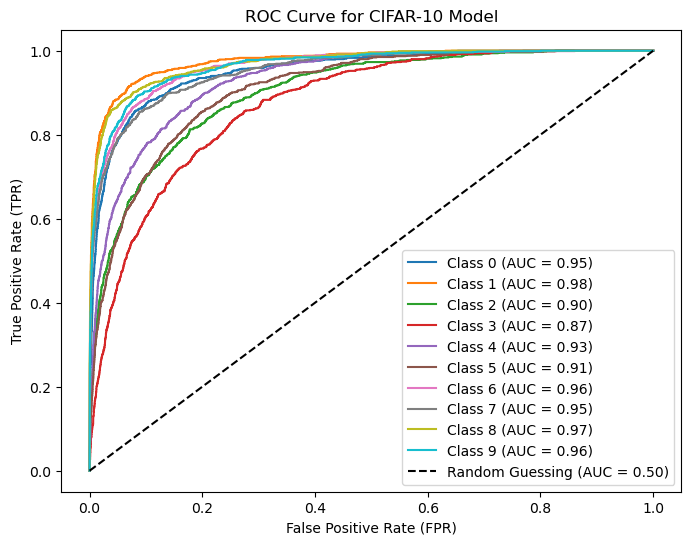

In [52]:
# Compute and plot ROC curves for each model
fpr_simple, tpr_simple, auc_simple = compute_fpr_tpr_auc(simple_cnn, X_test, y_test)
fpr_improved, tpr_improved, auc_improved = compute_fpr_tpr_auc(optimized_cnn, X_test, y_test)
fpr_adv_trained, tpr_adv_trained, auc_adv_trained = compute_fpr_tpr_auc(adv_trained_cnn, X_test, y_test)
fpr_hybrid, tpr_hybrid, auc_hybrid = compute_fpr_tpr_auc(hybrid_cnn, X_test, y_test)
